In [107]:
# !pip install uproot awkward mpl_scatter_density jupyter-dash zfit
# import uproot, scipy, math, os, random, time, pickle, collections
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import awkward as ak
# from tqdm import tqdm
# import pandas as pd
# from scipy import stats
# from scipy.spatial.distance import cdist
# from scipy.stats import iqr
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
f_fluk= uproot.open('/content/drive/MyDrive/data/TrackMatching/fluka_mc_test.root')
f_coll= uproot.open('/content/drive/MyDrive/data/TrackMatching/kfalignment_data_iter0.root')
f_ali_coll = uproot.open('/content/drive/MyDrive/data/TrackMatching/kfalignment_data_iter24.root')
# f_coll['trackParam'].show()

In [3]:
collision = f_coll['trackParam'].arrays(['fitParam_x',
                                         'fitParam_y',
                                         'fitParam_px',
                                         'fitParam_py',
                                         'fitParam_pz',
                                         'fitParam_nMeasurements',
                                         'fitParam_nOutliers',
                                         'fitParam_nStates',
                                         'fitParam_charge',
                                         'fitParam_align_unbiased_sp',
                                         'fitParam_align_stationId_sp',
                                         'fitParam_align_layerId_sp',
                                         'fitParam_align_moduleId_sp',
                                         'fitParam_align_stereoId',
                                         'fitParam_align_local_residual_x_sp',
                                         'fitParam_chi2',
                                         'fitParam_pz'], entry_stop=100000, library='ak')

In [4]:
ali_collision = f_ali_coll['trackParam'].arrays(['fitParam_x',
                                                 'fitParam_y',
                                                 'fitParam_px',
                                                 'fitParam_py',
                                                 'fitParam_pz',
                                                 'fitParam_nMeasurements', #num clusters used in track
                                                 'fitParam_nStates', #num clusters not used in track
                                                 'fitParam_nOutliers',
                                                 'fitParam_charge',
                                                 'fitParam_align_unbiased_sp',
                                                 'fitParam_align_stationId_sp',
                                                 'fitParam_align_layerId_sp',
                                                 'fitParam_align_moduleId_sp',
                                                 'fitParam_align_stereoId',
                                                 'fitParam_align_local_residual_x_sp',
                                                 'fitParam_chi2',
                                                 'fitParam_pz'], entry_stop=100000, library='ak')

In [5]:
fluka = f_fluk['trackParam'].arrays(['fitParam_x',
                                     'fitParam_y',
                                     'fitParam_px',
                                     'fitParam_py',
                                     'fitParam_pz',
                                     'fitParam_nMeasurements',
                                     'fitParam_nOutliers',
                                     'fitParam_nStates',
                                     'fitParam_charge',
                                     'fitParam_align_unbiased_sp',
                                     'fitParam_align_stationId_sp',
                                     'fitParam_align_layerId_sp',
                                     'fitParam_align_moduleId_sp',
                                     'fitParam_align_stereoId',
                                     'fitParam_align_local_residual_x_sp',
                                     'fitParam_chi2',
                                     'fitParam_pz'], library='ak')

In [7]:
def cut(data, station, charge, p_min, p_max):
    track_cutf = ak.where(ak.num(data['fitParam_pz'])==1)
    data1 = data[track_cutf]
    if charge==-1 or charge==1:
      cut = ak.where((ak.flatten(data1['fitParam_chi2']) < 100)&
                     (ak.flatten(data1['fitParam_charge']) == charge)&
                     (ak.flatten(data1['fitParam_pz']) >= p_min)&
                     (ak.flatten(data1['fitParam_pz']) < p_max)&
                     (ak.min(ak.flatten(data1['fitParam_align_stationId_sp']), axis=-1)==0)&
                     (ak.min(ak.flatten(data1['fitParam_align_layerId_sp']), axis=-1)==0)&
                     (ak.flatten(data1['fitParam_nMeasurements']) > 15))
    else:
      cut = ak.where((ak.flatten(data1['fitParam_chi2']) < 100)&
                     (ak.flatten(data1['fitParam_pz']) >= p_min)&
                     (ak.flatten(data1['fitParam_pz']) < p_max)&
                     (ak.min(ak.flatten(data1['fitParam_align_stationId_sp']), axis=-1)==0)&
                     (ak.min(ak.flatten(data1['fitParam_align_layerId_sp']), axis=-1)==0)&
                     (ak.flatten(data1['fitParam_nMeasurements']) > 15))
    
    
    res_x = ak.flatten(ak.flatten(data1['fitParam_align_local_residual_x_sp'])[cut])
    sta = ak.flatten(ak.flatten(data1['fitParam_align_stationId_sp'])[cut])
    bias = ak.flatten(ak.flatten(data1['fitParam_align_unbiased_sp'])[cut])

    if station==0:
        return res_x[ak.where((sta==station)&(bias==2))]
    else: 
        return res_x[ak.where(sta==station)]

In [8]:
def cut_ext(data, station, charge, p_min, p_max):
    track_cutf = ak.where(ak.num(data['fitParam_pz'])==1)
    data1 = data[track_cutf]
    tx = ak.flatten(data1['fitParam_px']) / ak.flatten(data1['fitParam_pz'])
    ty = ak.flatten(data1['fitParam_py']) / ak.flatten(data1['fitParam_pz'])

    if charge==-1 or charge==1:
      cut = ak.where((abs(tx)<0.005)&
                     (abs(ty)<0.005)&
                     (ak.flatten(data1['fitParam_chi2']) < 100)&
                     (ak.flatten(data1['fitParam_charge']) == charge)&
                     (ak.flatten(data1['fitParam_pz']) >= p_min)&
                     (ak.flatten(data1['fitParam_pz']) < p_max)&
                     (ak.min(ak.flatten(data1['fitParam_align_stationId_sp']), axis=-1)==0)&
                     (ak.min(ak.flatten(data1['fitParam_align_layerId_sp']), axis=-1)==0)&              
                     (ak.flatten(data1['fitParam_nMeasurements']) > 15))
    else:
      cut = ak.where((abs(tx)<0.005)&
                     (abs(ty)<0.005)&
                     (ak.flatten(data1['fitParam_chi2']) < 100)&
                     (ak.flatten(data1['fitParam_pz']) >= p_min)&
                     (ak.flatten(data1['fitParam_pz']) < p_max)&
                     (ak.min(ak.flatten(data1['fitParam_align_stationId_sp']), axis=-1)==0)&
                     (ak.min(ak.flatten(data1['fitParam_align_layerId_sp']), axis=-1)==0)&
                     (ak.flatten(data1['fitParam_nMeasurements']) > 15))
    

    
    res_x = ak.flatten(ak.flatten(data1['fitParam_align_local_residual_x_sp'])[cut])
    sta = ak.flatten(ak.flatten(data1['fitParam_align_stationId_sp'])[cut])
    bias = ak.flatten(ak.flatten(data1['fitParam_align_unbiased_sp'])[cut])

    if station==0:
        return res_x[ak.where((sta==station)&(bias==2))]
    else: 
        return res_x[ak.where(sta==station)]

In [87]:
def plot(charge, p_min, p_max, cutting):
    plt.figure(figsize=(46, 10))
    plt.subplots_adjust(hspace=0.2, wspace=0.2)

    sta=0

    plt.subplot(1, 4, 1)
    plt.hist(cutting(fluka, sta, charge, p_min, p_max), histtype='step', linewidth=2.5, bins=np.linspace(-5, 5, 51), density=True, alpha=0.8, label=f'Fluka µ: {round(np.median(cutting(fluka, sta, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(fluka, sta, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(collision, sta, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-5, 5, 51), alpha=0.8, label=f'Data µ: {round(np.median(cutting(collision, sta, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(collision, sta, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(ali_collision, sta, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-5, 5, 51), alpha=0.8, label=f'Alig. Data µ: {round(np.median(cutting(ali_collision, sta, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(ali_collision, sta, charge, p_min, p_max)), 2)}')
    plt.xlabel('Unbiased Residual x (mm)', fontsize=18)
    plt.ylabel('Number of Events', fontsize=18)
    plt.legend(fontsize=14, title=f'{p_min}<Pz<{p_max}, Charge={charge}')
    plt.xticks(fontsize=15)
    plt.xlim(-5, 5)
    plt.title(f'station={sta}', fontsize=24)

    plt.subplot(1, 4, 2)
    plt.hist(cutting(fluka, sta+1, charge, p_min, p_max), histtype='step', linewidth=2.5, bins=np.linspace(-0.2, 0.2, 51), density=True, alpha=0.8, label=f'Fluka µ: {round(np.median(cutting(fluka, sta+1, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(fluka, sta+1, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(collision, sta+1, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-0.2, 0.2, 51), alpha=0.8, label=f'Data µ: {round(np.median(cutting(collision, sta+1, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(collision, sta+1, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(ali_collision, sta+1, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-0.2, 0.2, 51), alpha=0.8, label=f'Alig. Data µ: {round(np.median(cutting(ali_collision, sta+1, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(ali_collision, sta+1, charge, p_min, p_max)), 2)}')
    plt.xlabel('Biased Residual x (mm)', fontsize=18)
    plt.ylabel('Number of Events', fontsize=18)
    plt.legend(fontsize=14, title=f'{p_min}<Pz<{p_max}, Charge={charge}')
    plt.xticks(fontsize=15)
    plt.xlim(-0.2, 0.2)
    plt.title(f'station={sta+1}', fontsize=24)

    plt.subplot(1, 4, 3)
    plt.hist(cutting(fluka, sta+2, charge, p_min, p_max), histtype='step', linewidth=2.5, bins=np.linspace(-0.2, 0.2, 51), density=True, alpha=0.8, label=f'Fluka µ: {round(np.median(cutting(fluka, sta+2, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(fluka, sta+2, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(collision, sta+2, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-0.2, 0.2, 51), alpha=0.8, label=f'Data µ: {round(np.median(cutting(collision, sta+2, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(collision, sta+2, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(ali_collision, sta+2, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-0.2, 0.2, 51), alpha=0.8, label=f'Alig. Data µ: {round(np.median(cutting(ali_collision, sta+2, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(ali_collision, sta+2, charge, p_min, p_max)), 2)}')
    plt.xlabel('Biased Residual x (mm)', fontsize=18)
    plt.ylabel('Number of Events', fontsize=18)
    plt.legend(fontsize=14, title=f'{p_min}<Pz<{p_max}, Charge={charge}')
    plt.xticks(fontsize=15)
    plt.xlim(-0.2, 0.2)
    plt.title(f'station={sta+2}', fontsize=24)

    plt.subplot(1, 4, 4)
    plt.hist(cutting(fluka, sta+3, charge, p_min, p_max), histtype='step', linewidth=2.5, bins=np.linspace(-0.2, 0.2, 121), density=True, alpha=0.8, label=f'Fluka µ: {round(np.median(cutting(fluka, sta+3, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(fluka, sta+3, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(collision, sta+3, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-0.2, 0.2, 121), alpha=0.8, label=f'Data µ: {round(np.median(cutting(collision, sta+3, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(collision, sta+3, charge, p_min, p_max)), 2)}')
    plt.hist(cutting(ali_collision, sta+3, charge, p_min, p_max),histtype='step', linewidth=2.5, density=True, bins=np.linspace(-0.2, 0.2, 121), alpha=0.8, label=f'Alig. Data µ: {round(np.median(cutting(ali_collision, sta+3, charge, p_min, p_max)), 2)}, IQR50: {round(iqr(cutting(ali_collision, sta+3, charge, p_min, p_max)), 2)}')
    plt.xlabel('Biased Residual x (mm)', fontsize=18)
    plt.ylabel('Number of Events', fontsize=18)
    plt.legend(fontsize=14, title=f'{p_min}<Pz<{p_max}, Charge={charge}')
    plt.xticks(fontsize=15)
    plt.xlim(-0.2, 0.2)
    plt.title(f'station={sta+3}', fontsize=24)

    plt.show()

# **When using Plot the first arguement is charge (0 for all charge), second is min Pz, third is max Pz, and last is choice of one of two selection cuts defined above (cut_ext includes all selection of cut in addition to Tx and Ty cuts).**


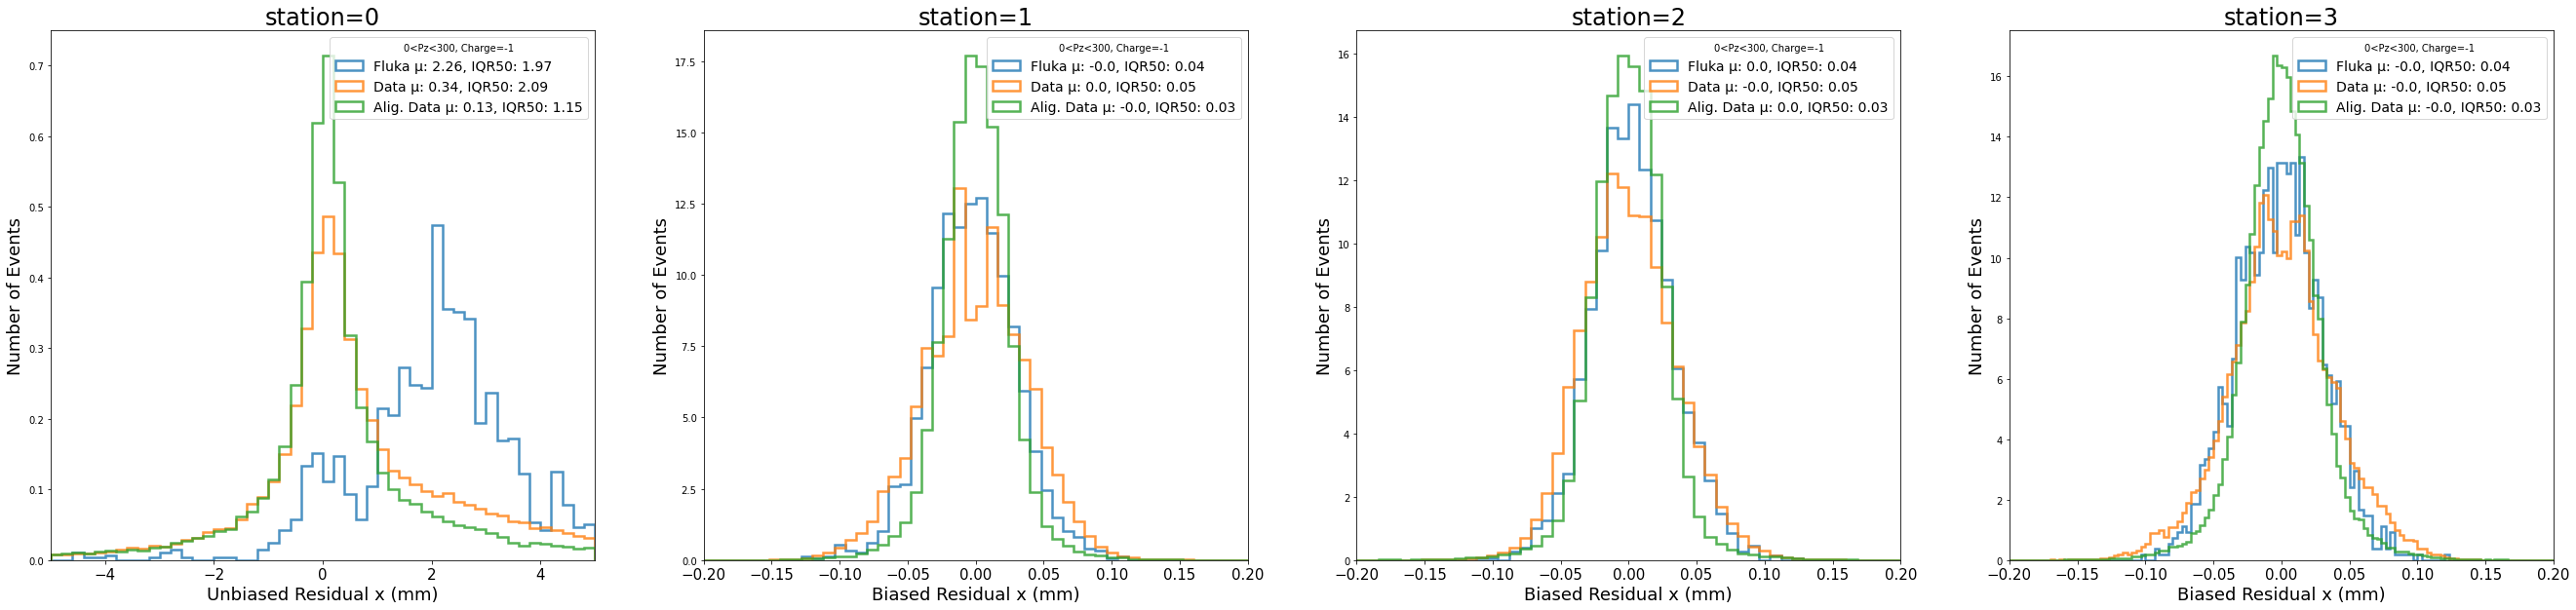

In [90]:
plot(-1, 0, 300, cut)

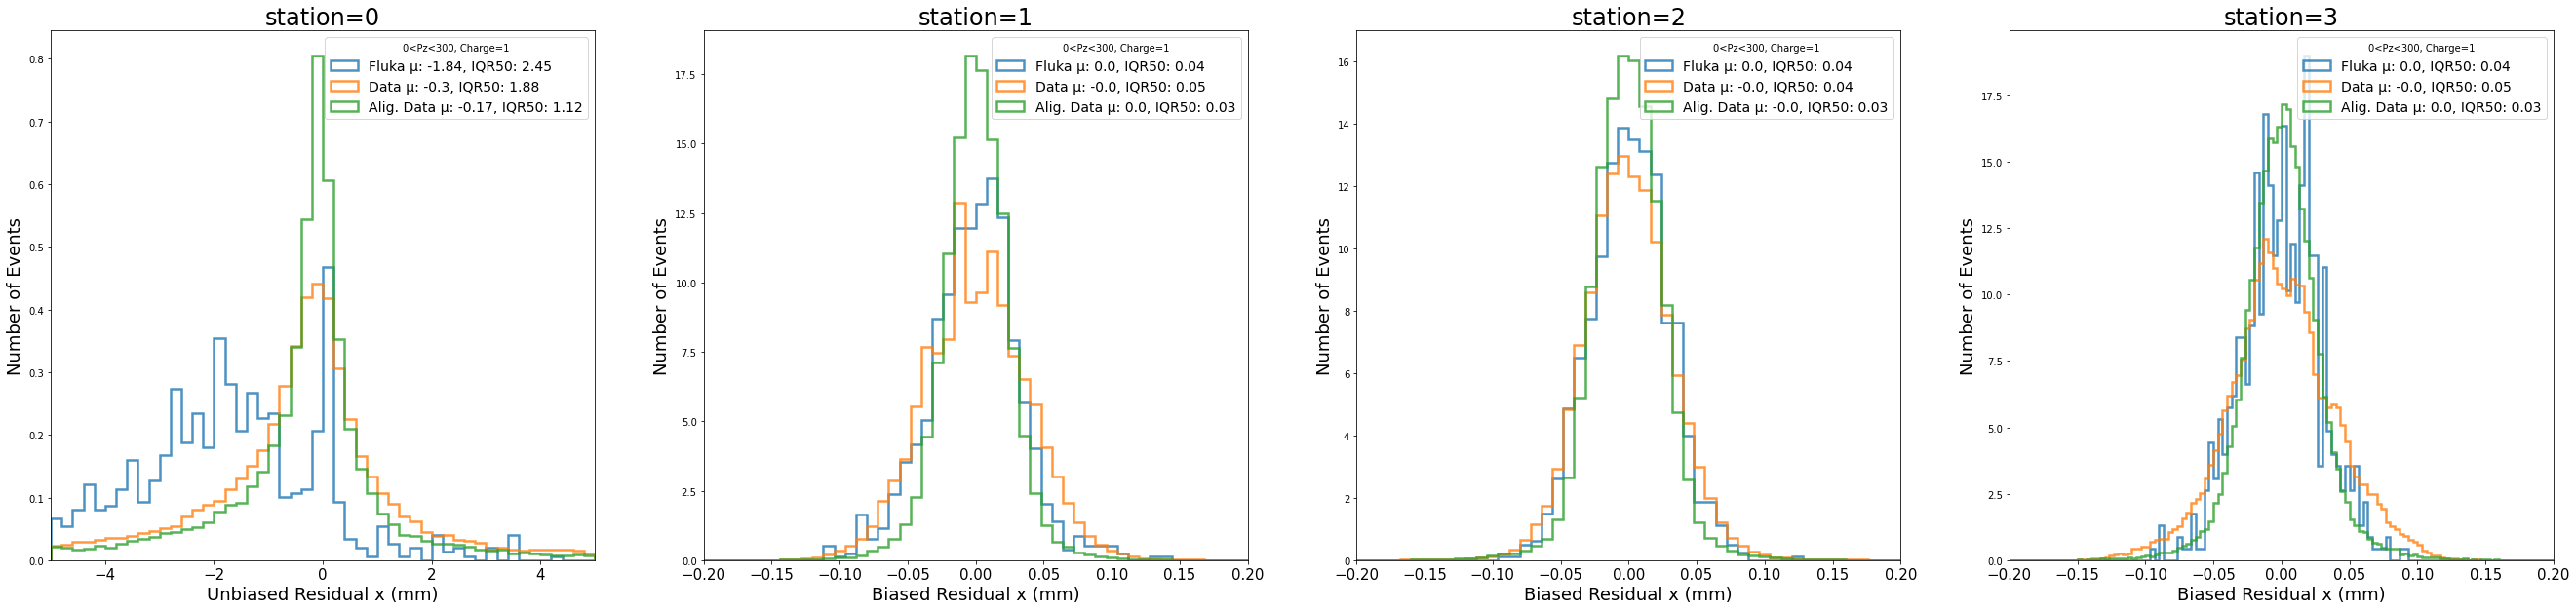

In [91]:
plot(1, 0, 300, cut)

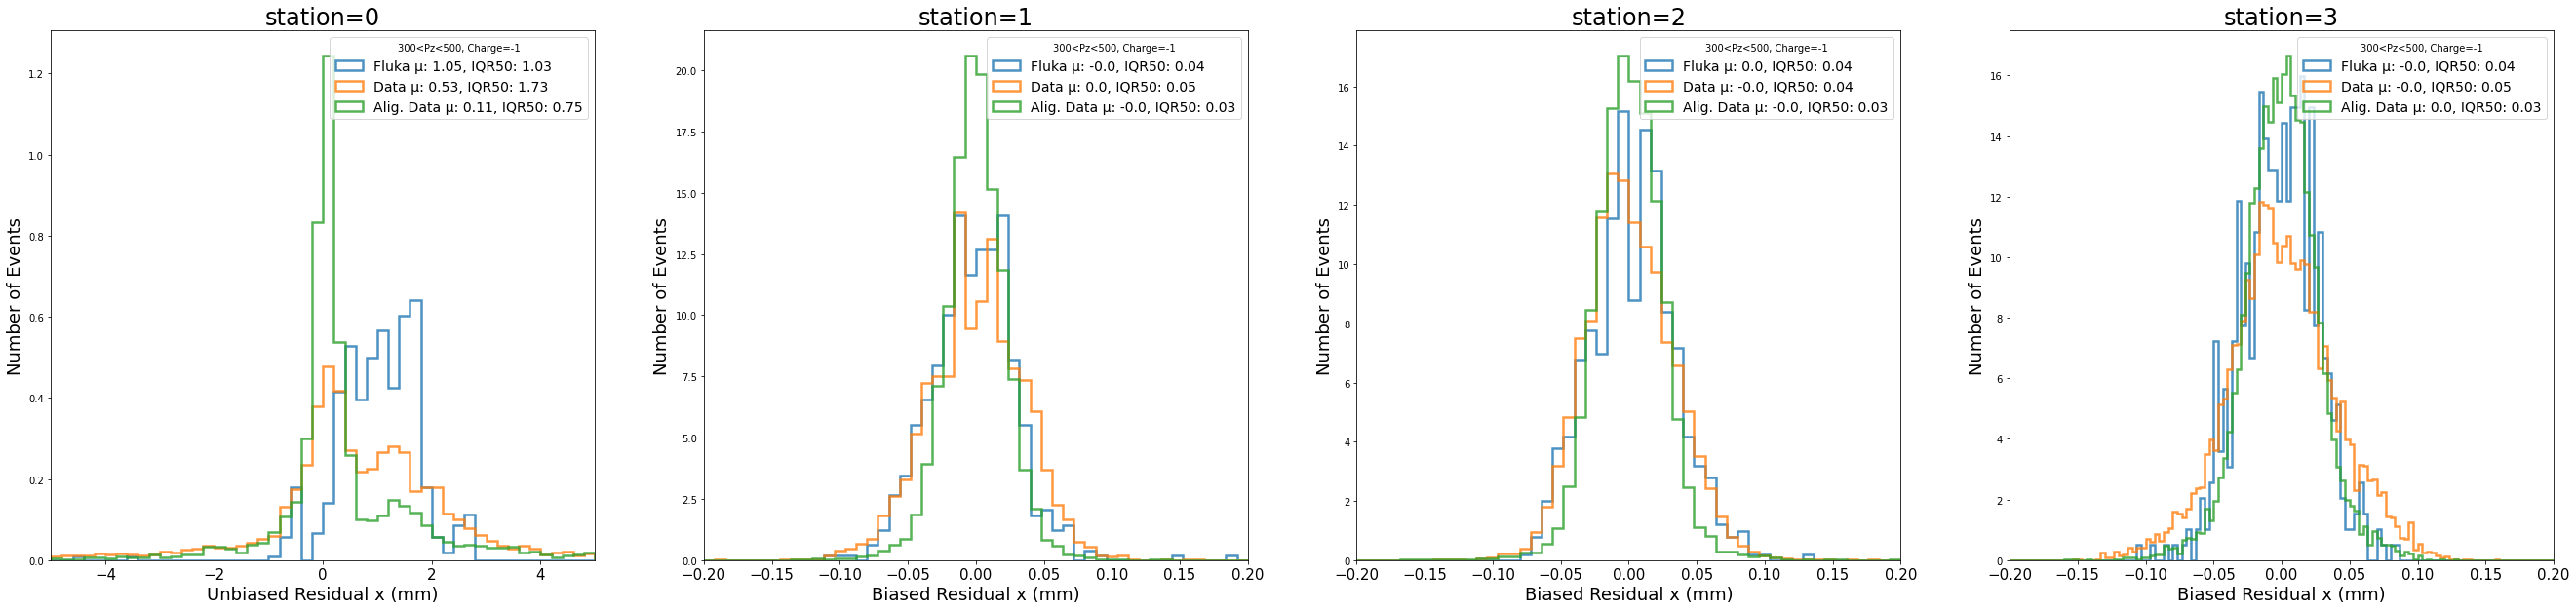

In [92]:
plot(-1, 300, 500, cut)

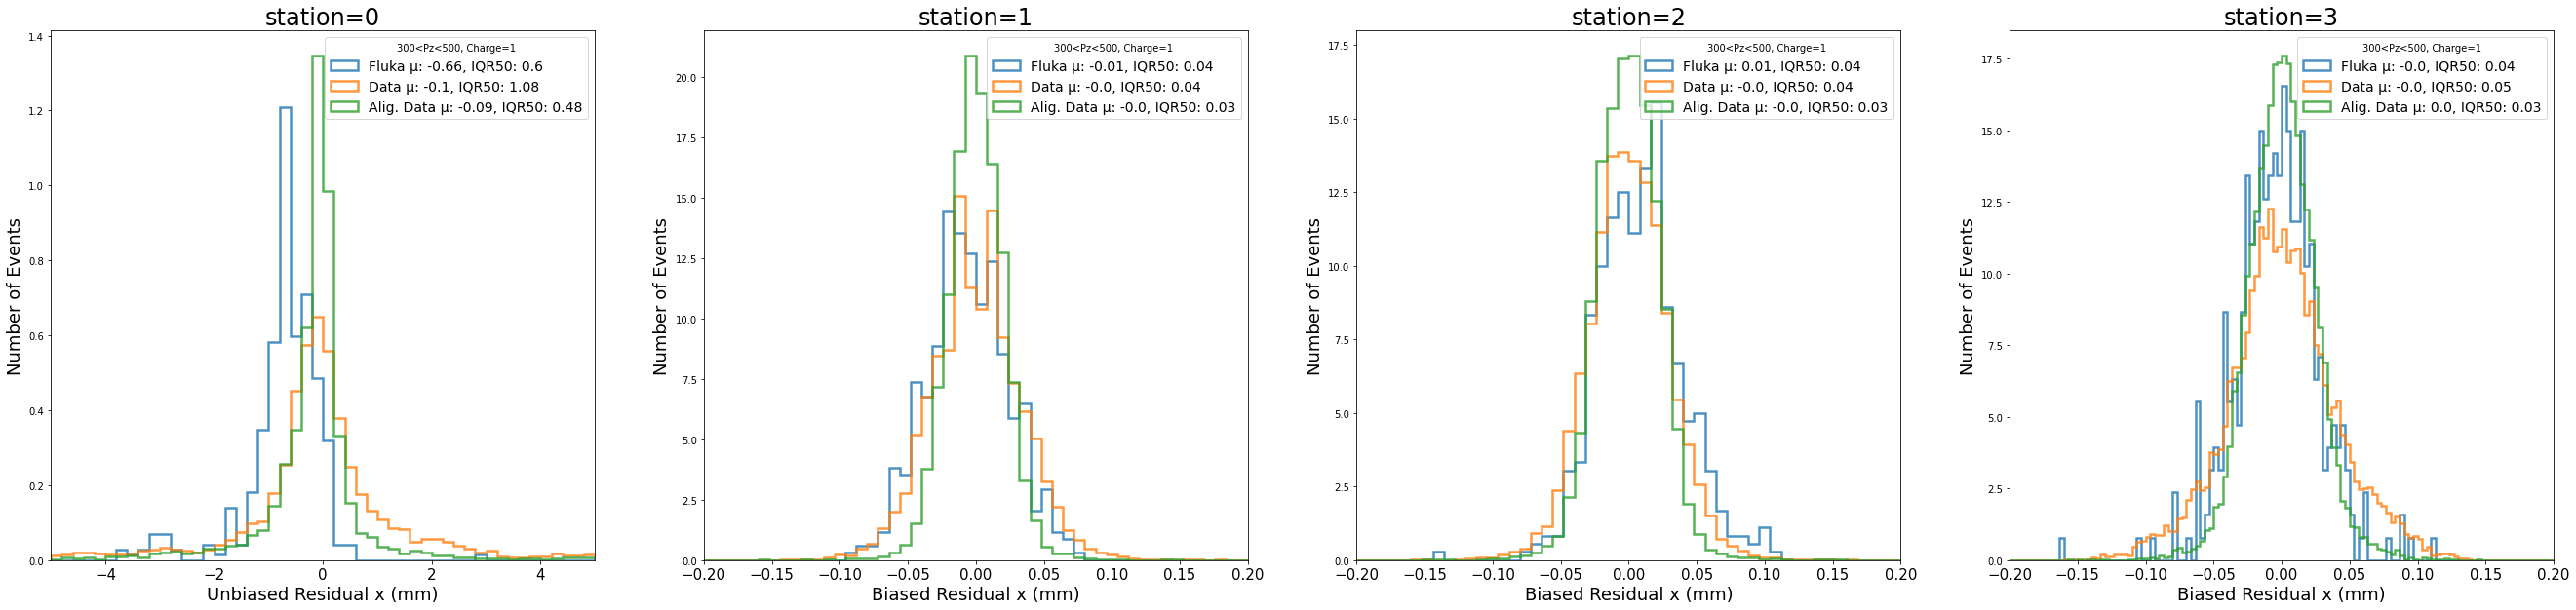

In [93]:
plot(1, 300, 500, cut)

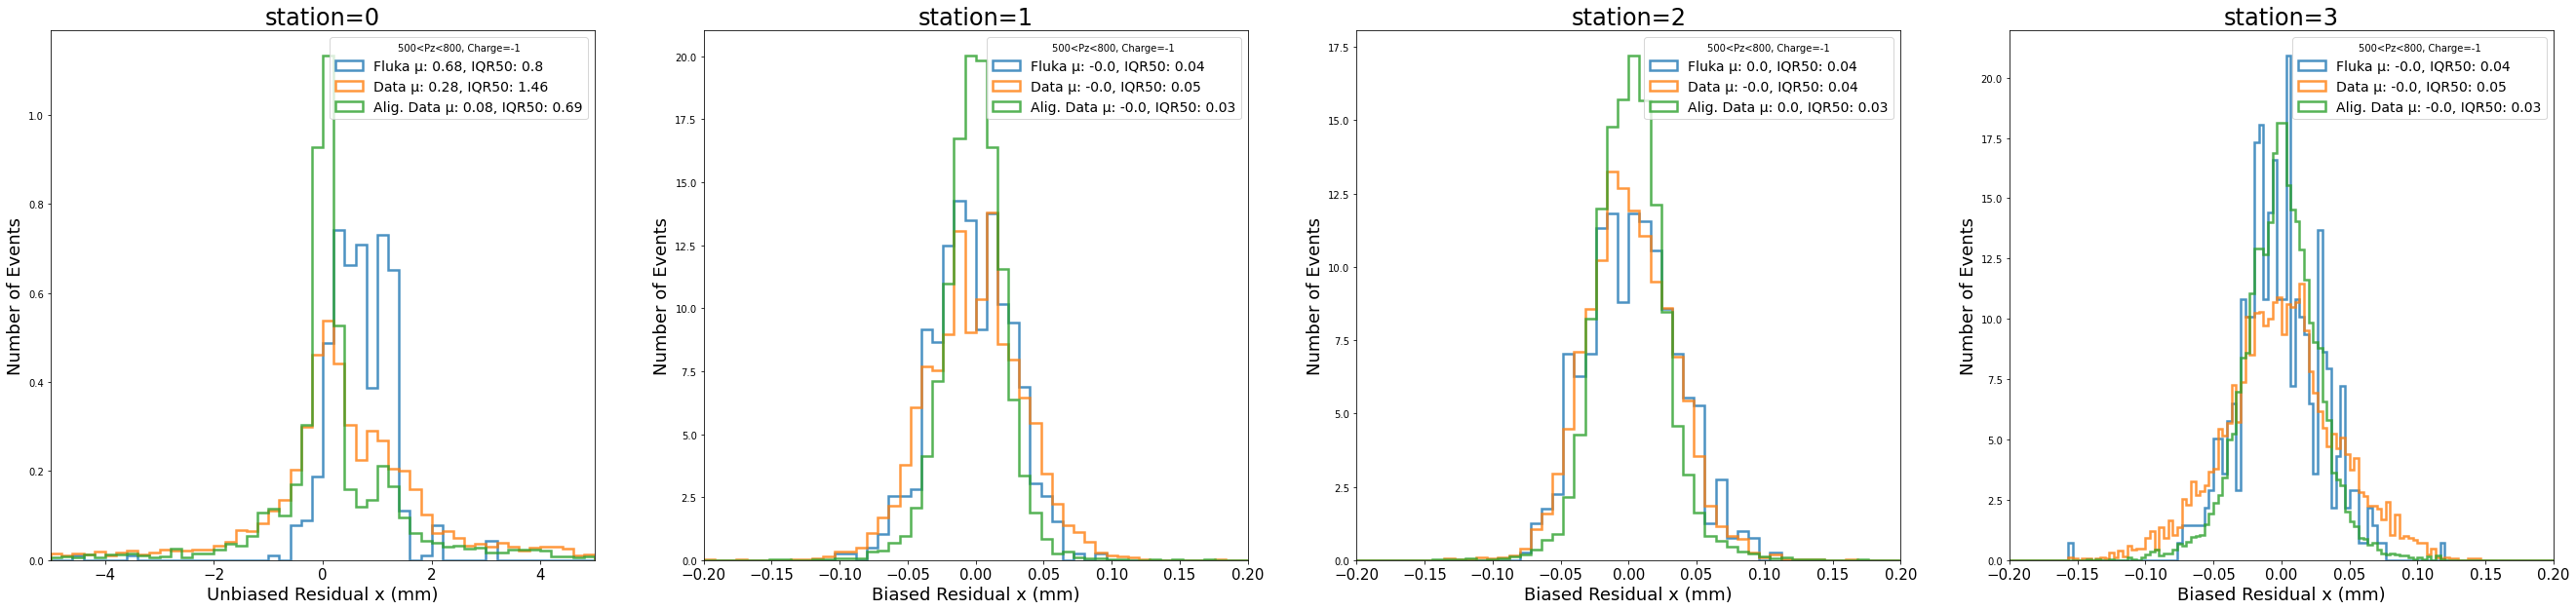

In [94]:
plot(-1, 500, 800, cut)

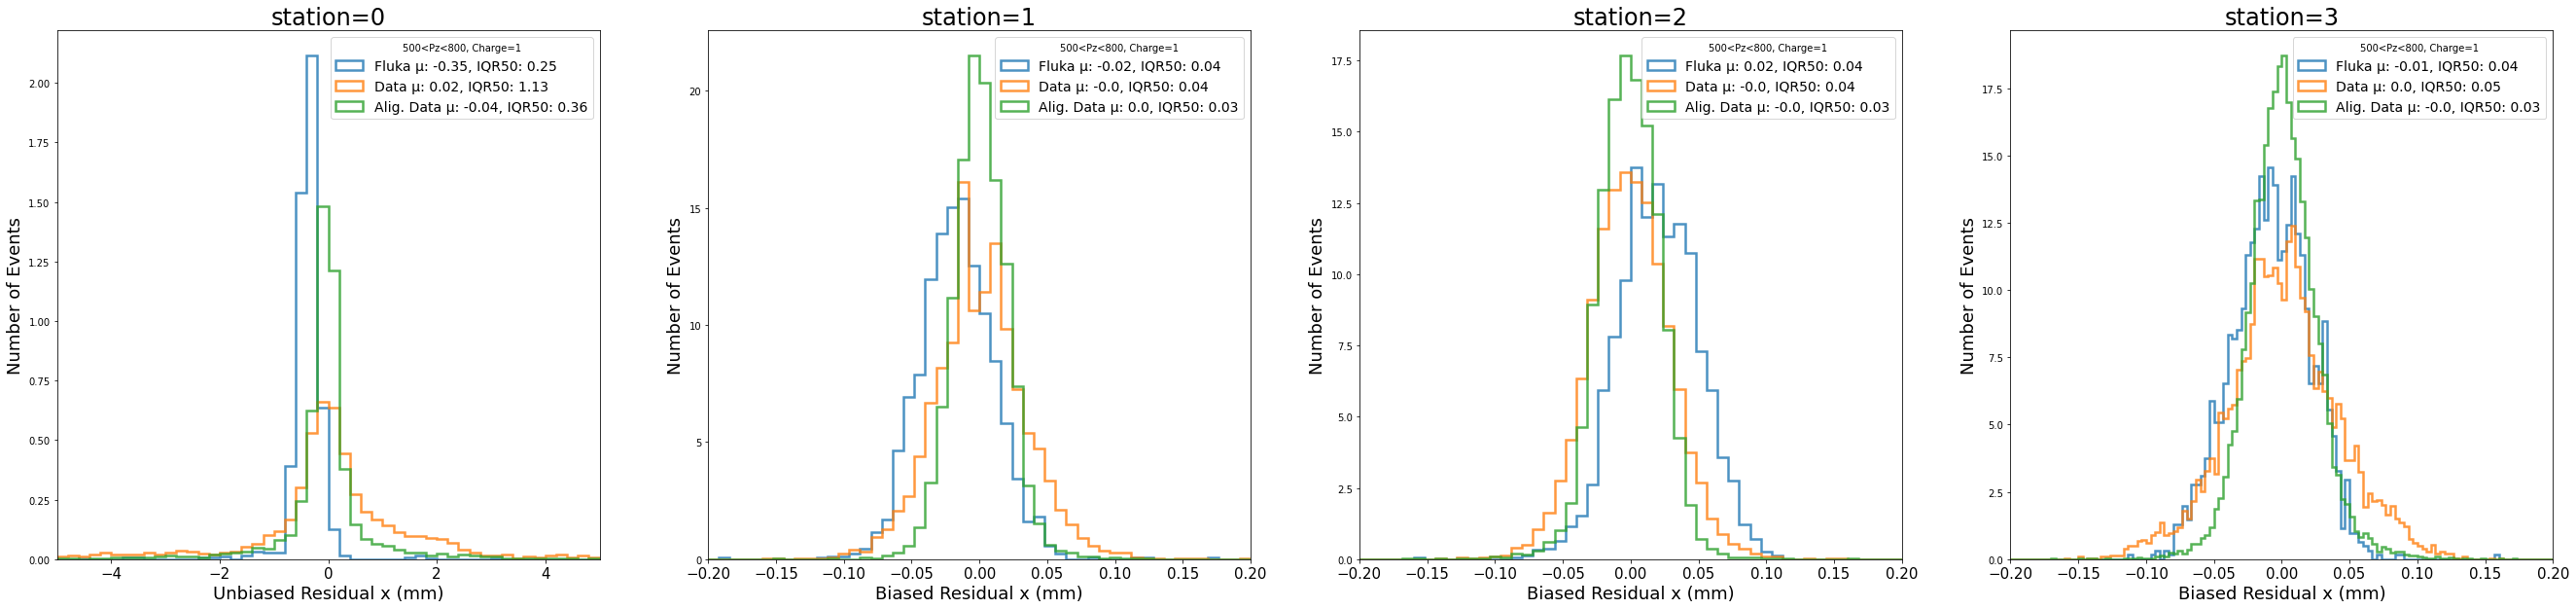

In [95]:
plot(1, 500, 800, cut)

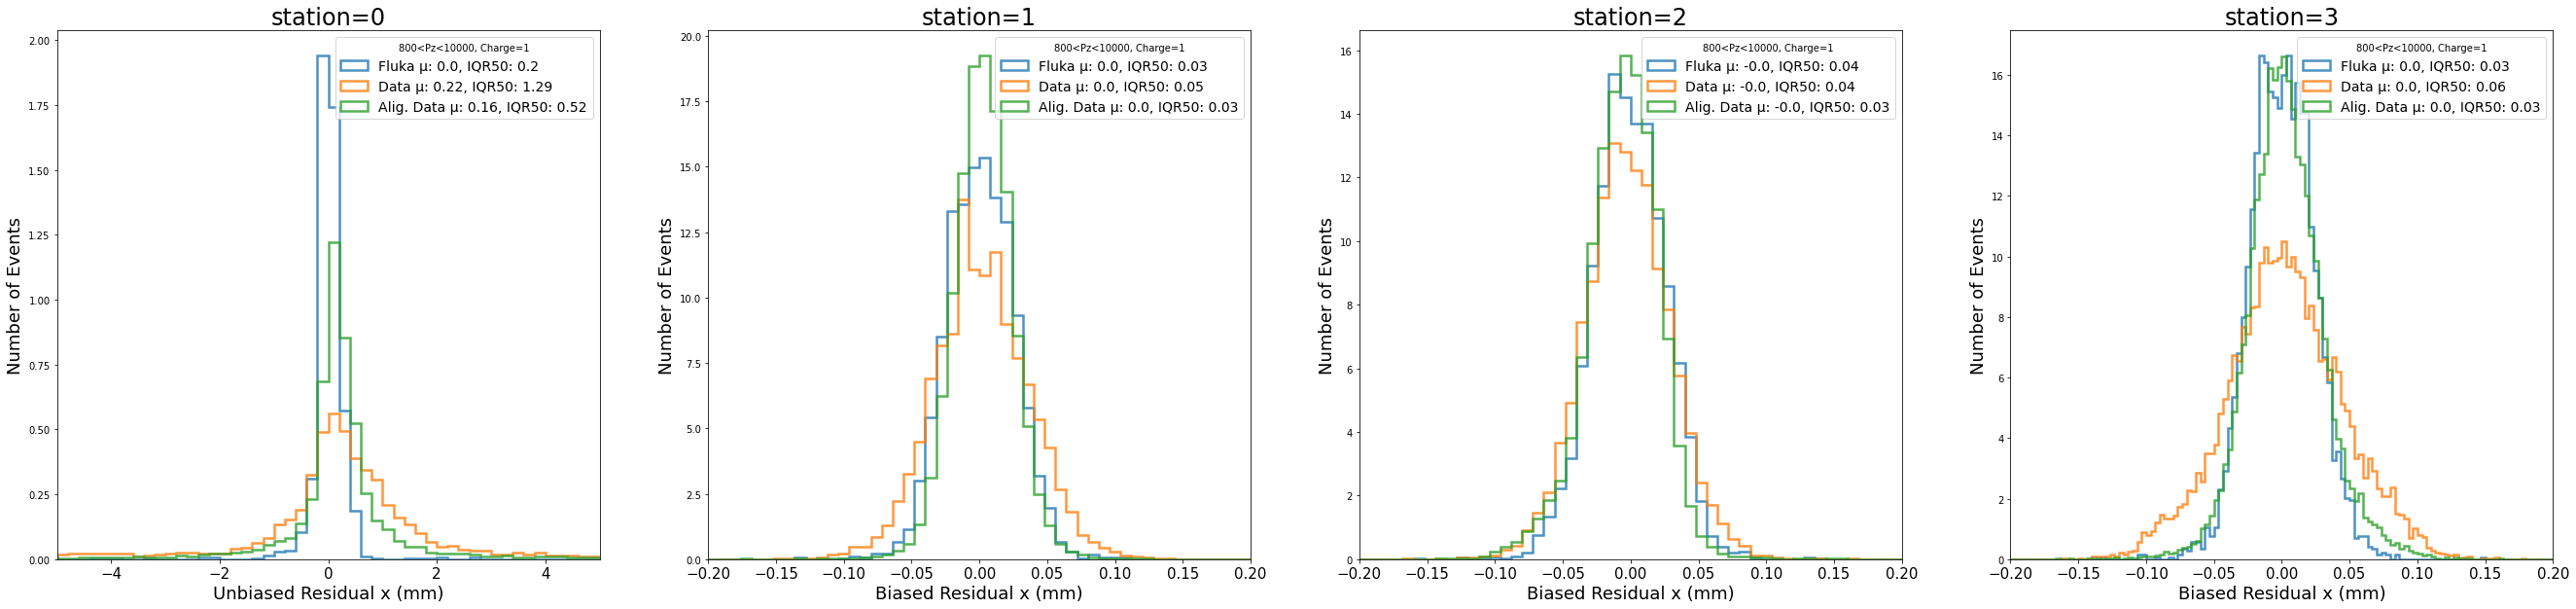

In [96]:
plot(1, 800, 10000, cut)

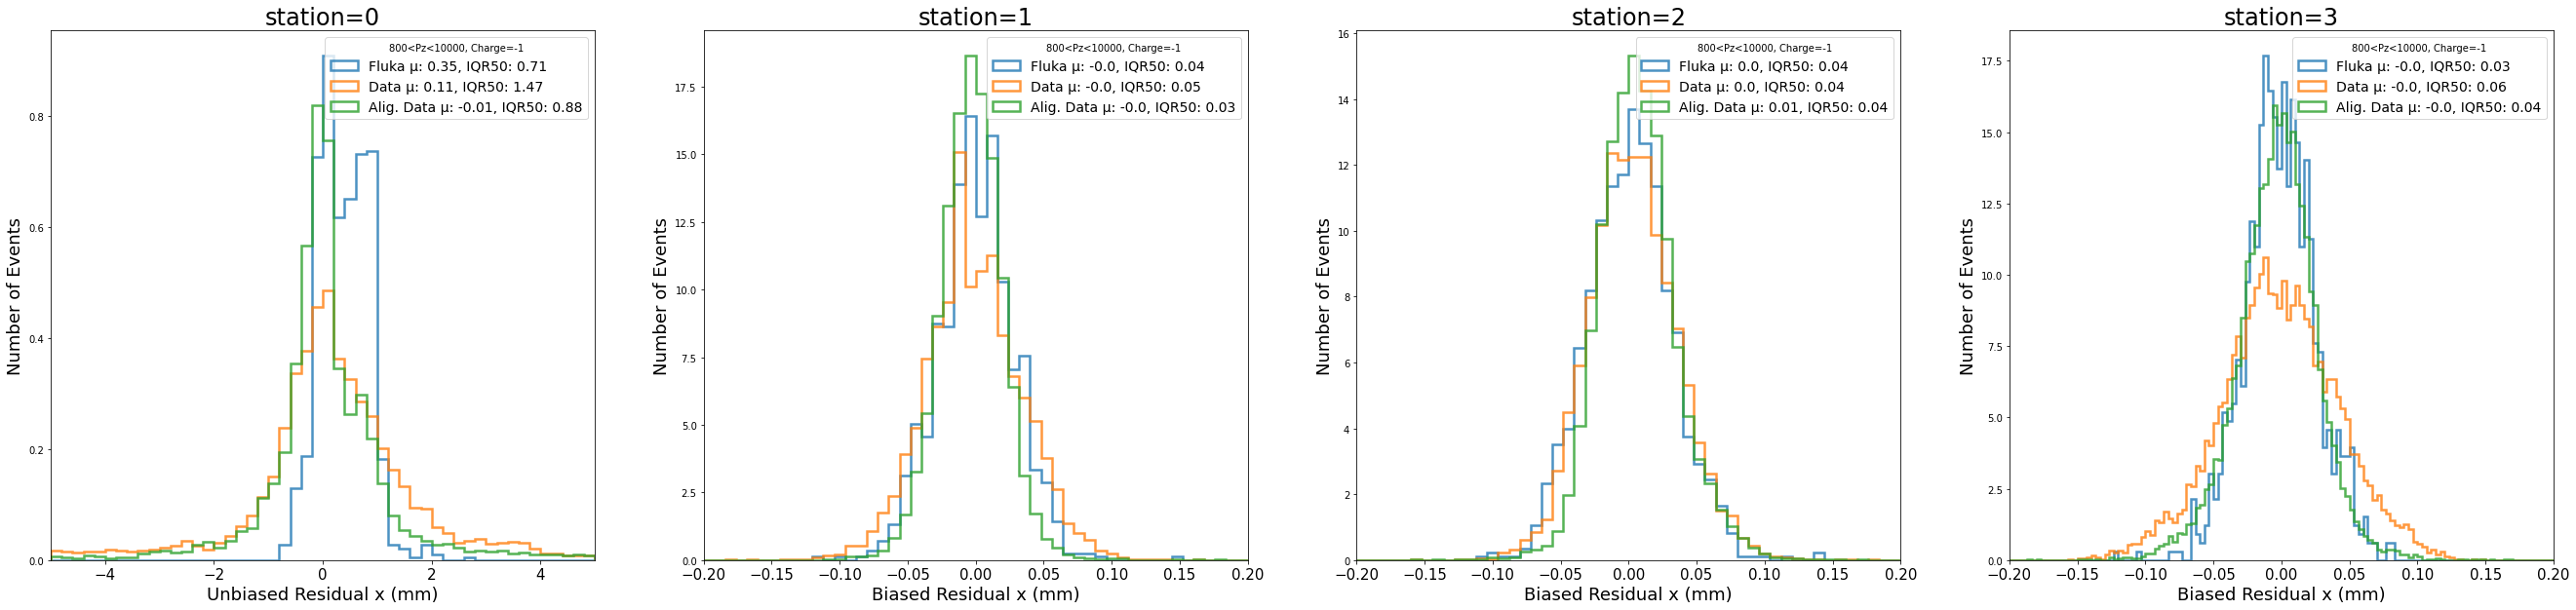

In [97]:
plot(-1, 800, 10000, cut)

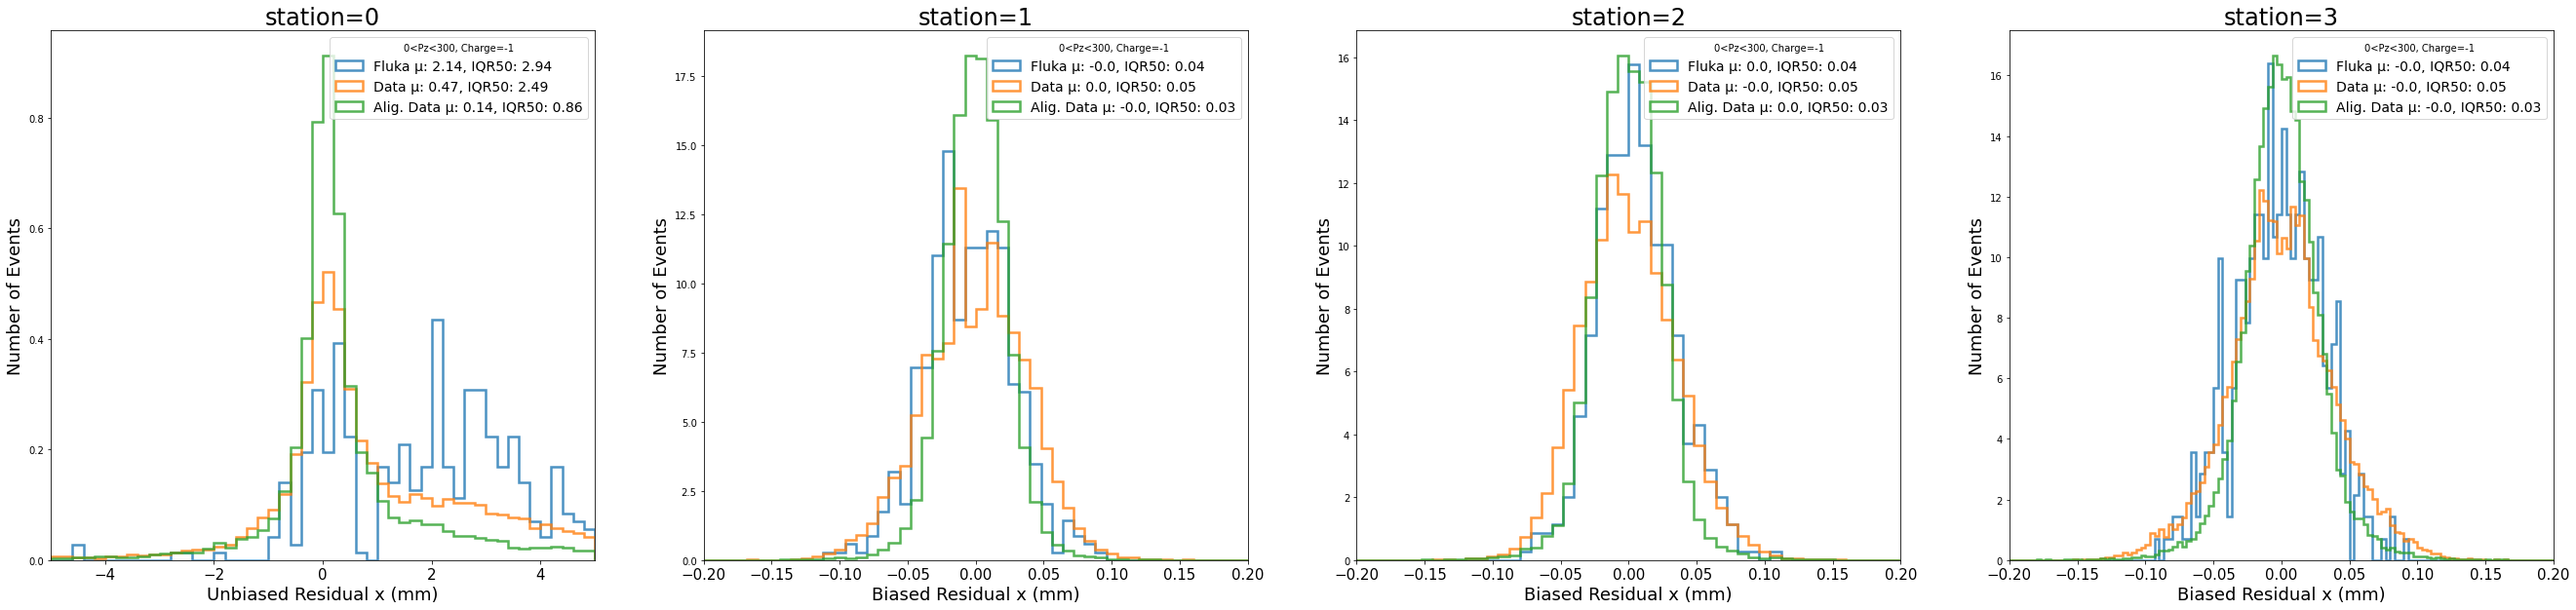

In [98]:
plot(-1, 0, 300, cut_ext)

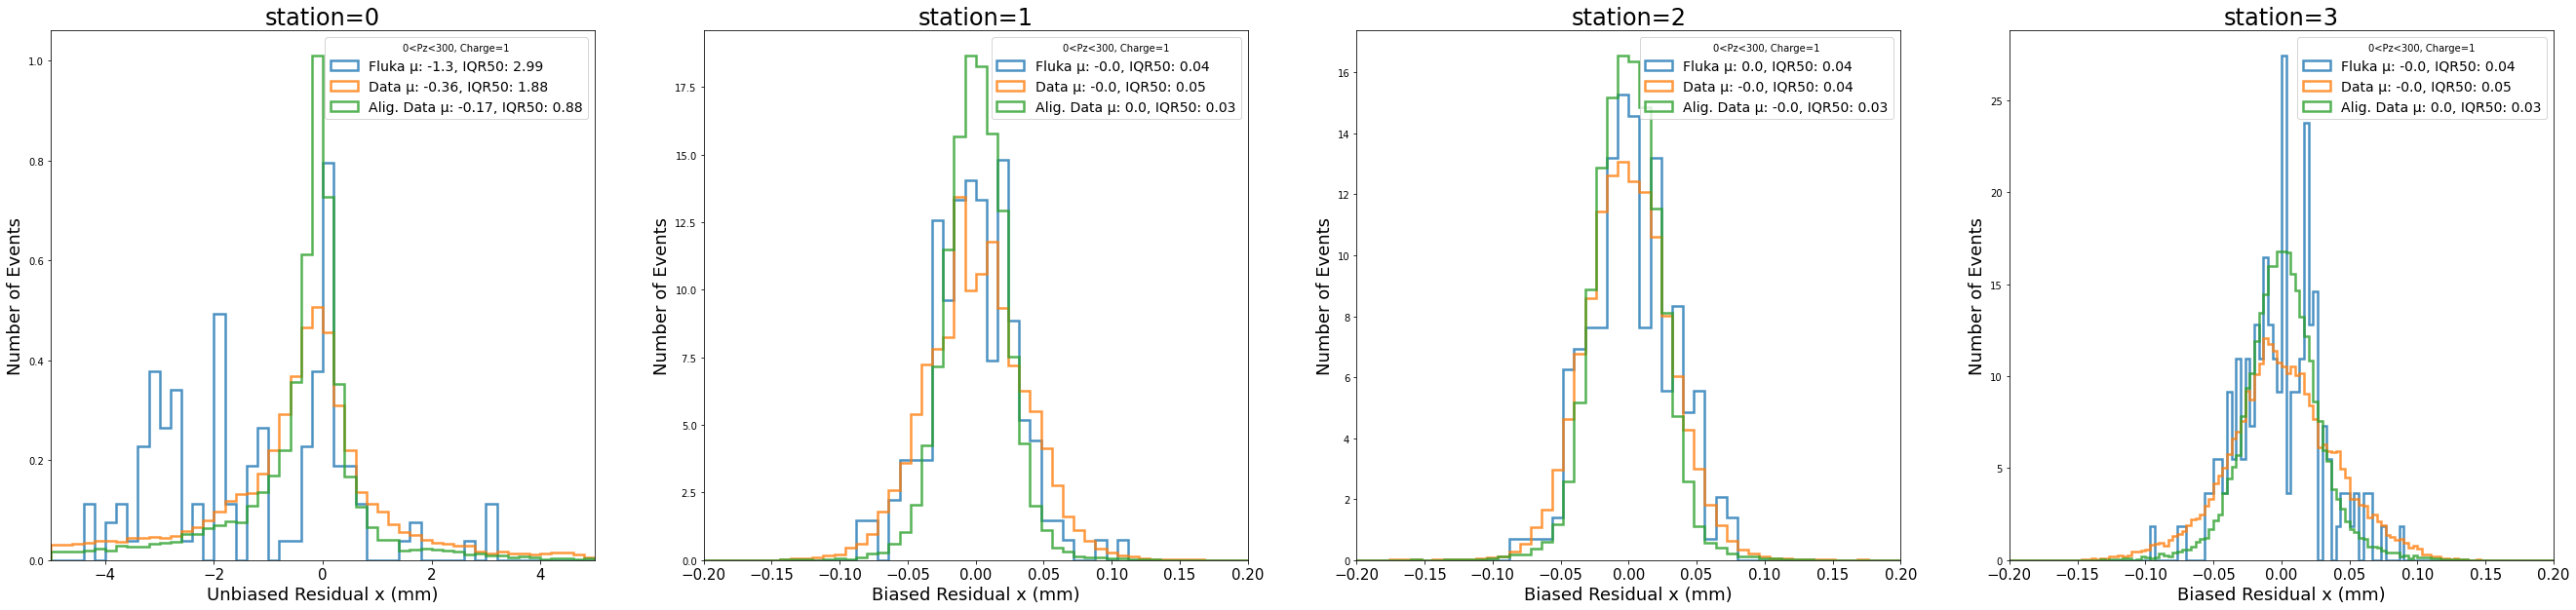

In [99]:
plot(1, 0, 300, cut_ext)

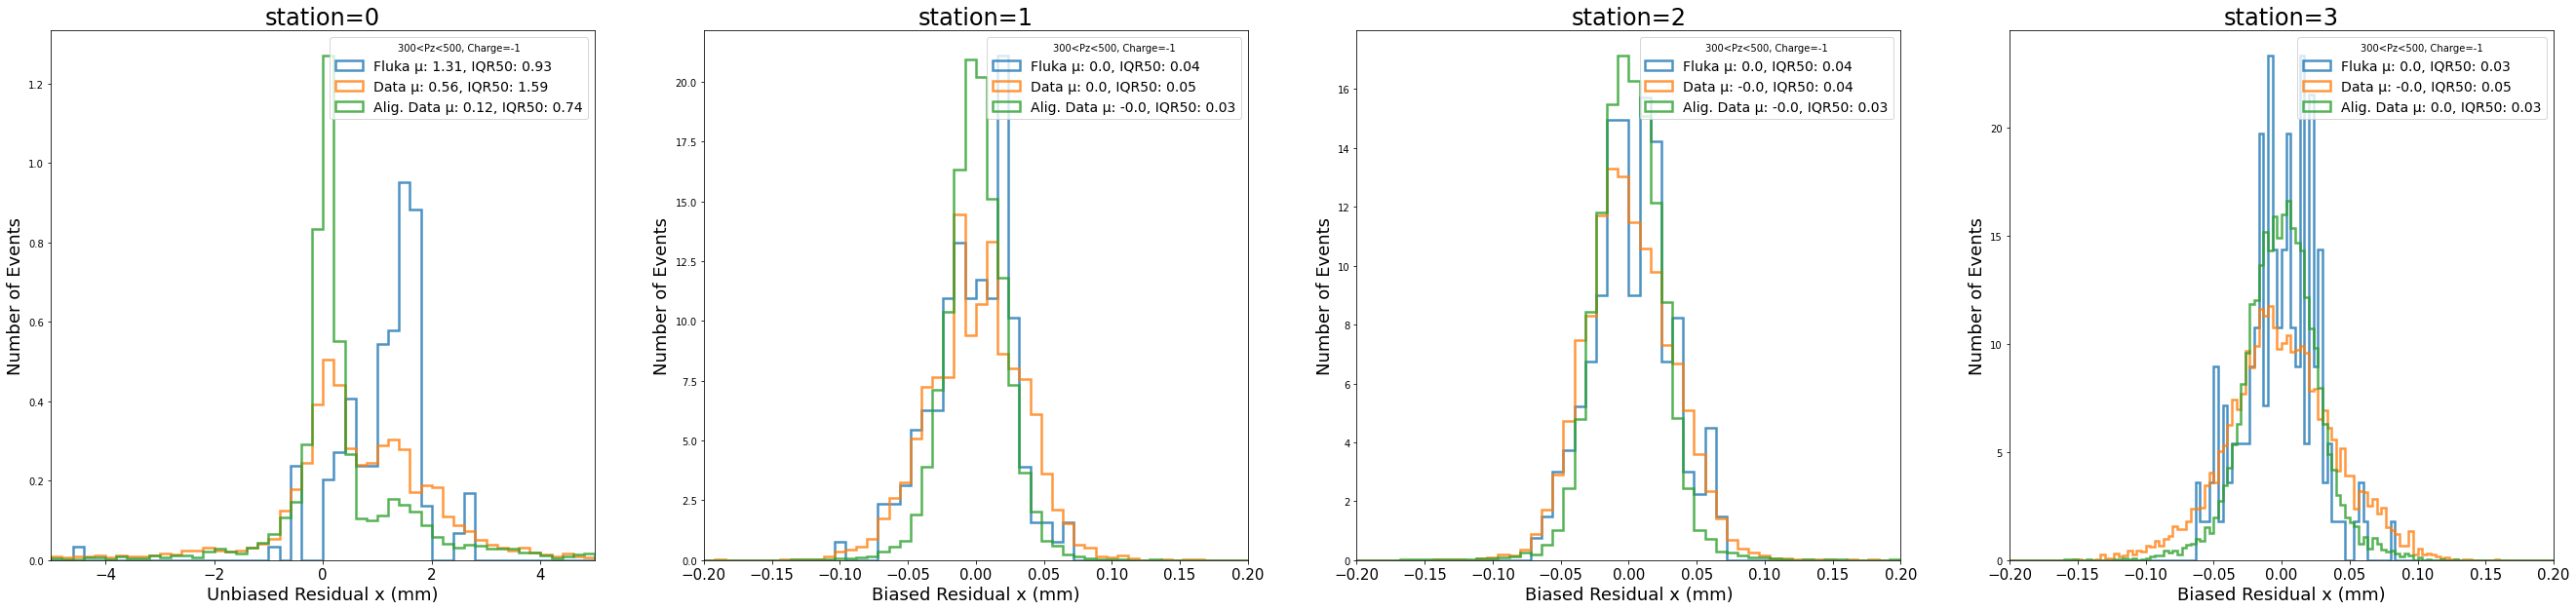

In [100]:
plot(-1, 300, 500, cut_ext)

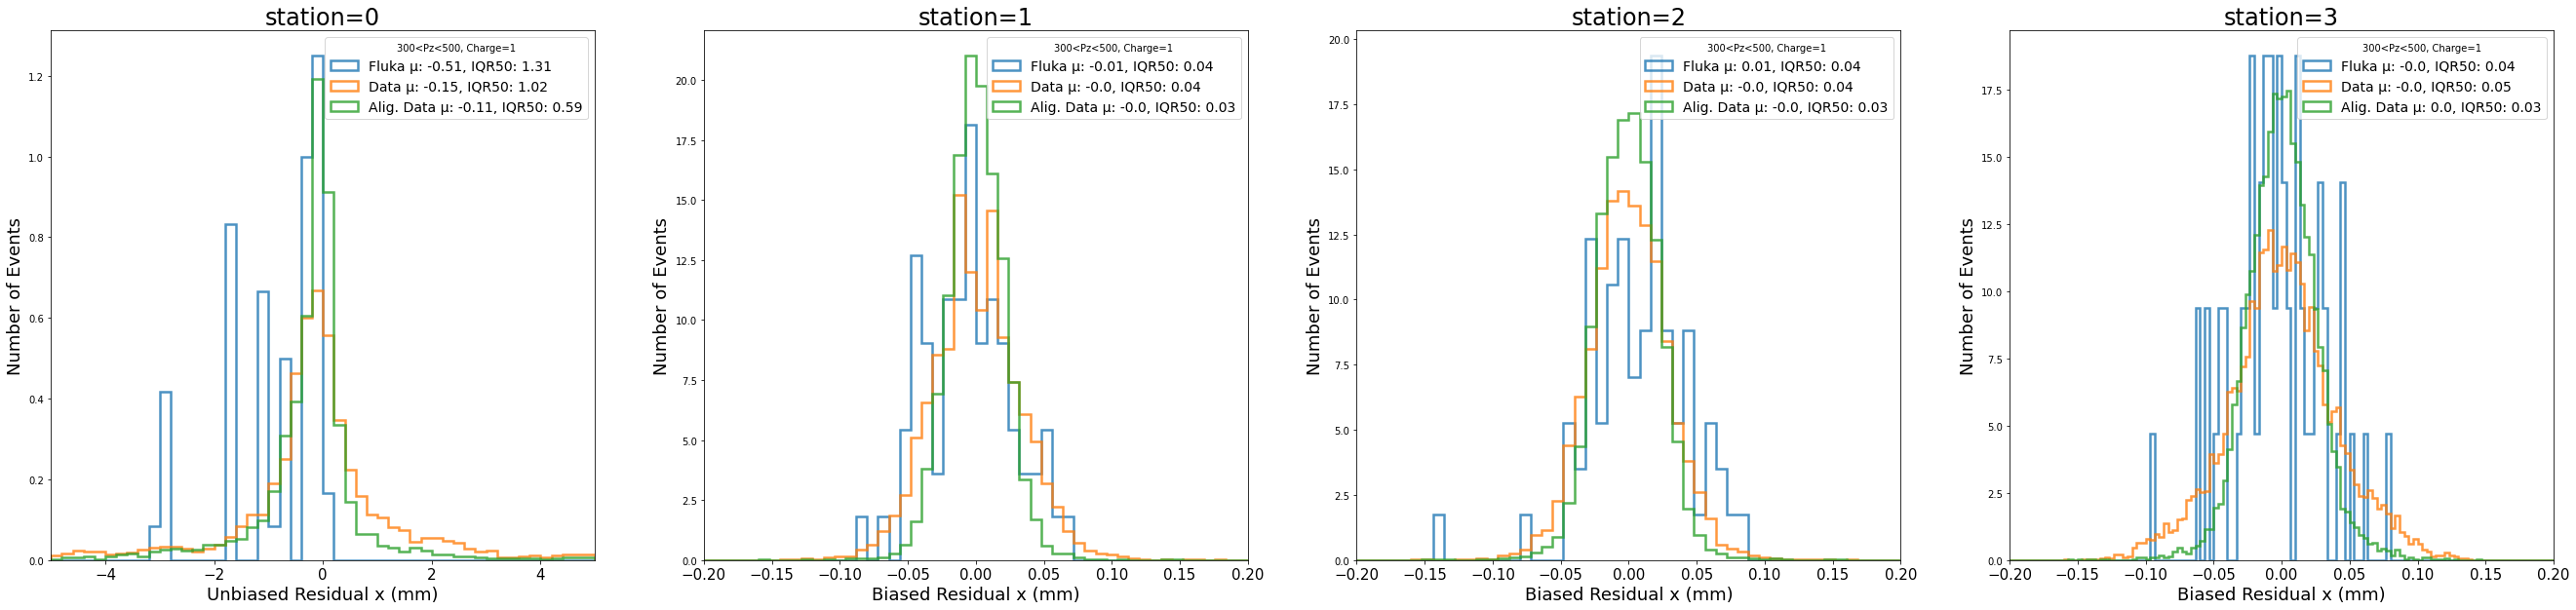

In [101]:
plot(1, 300, 500, cut_ext)

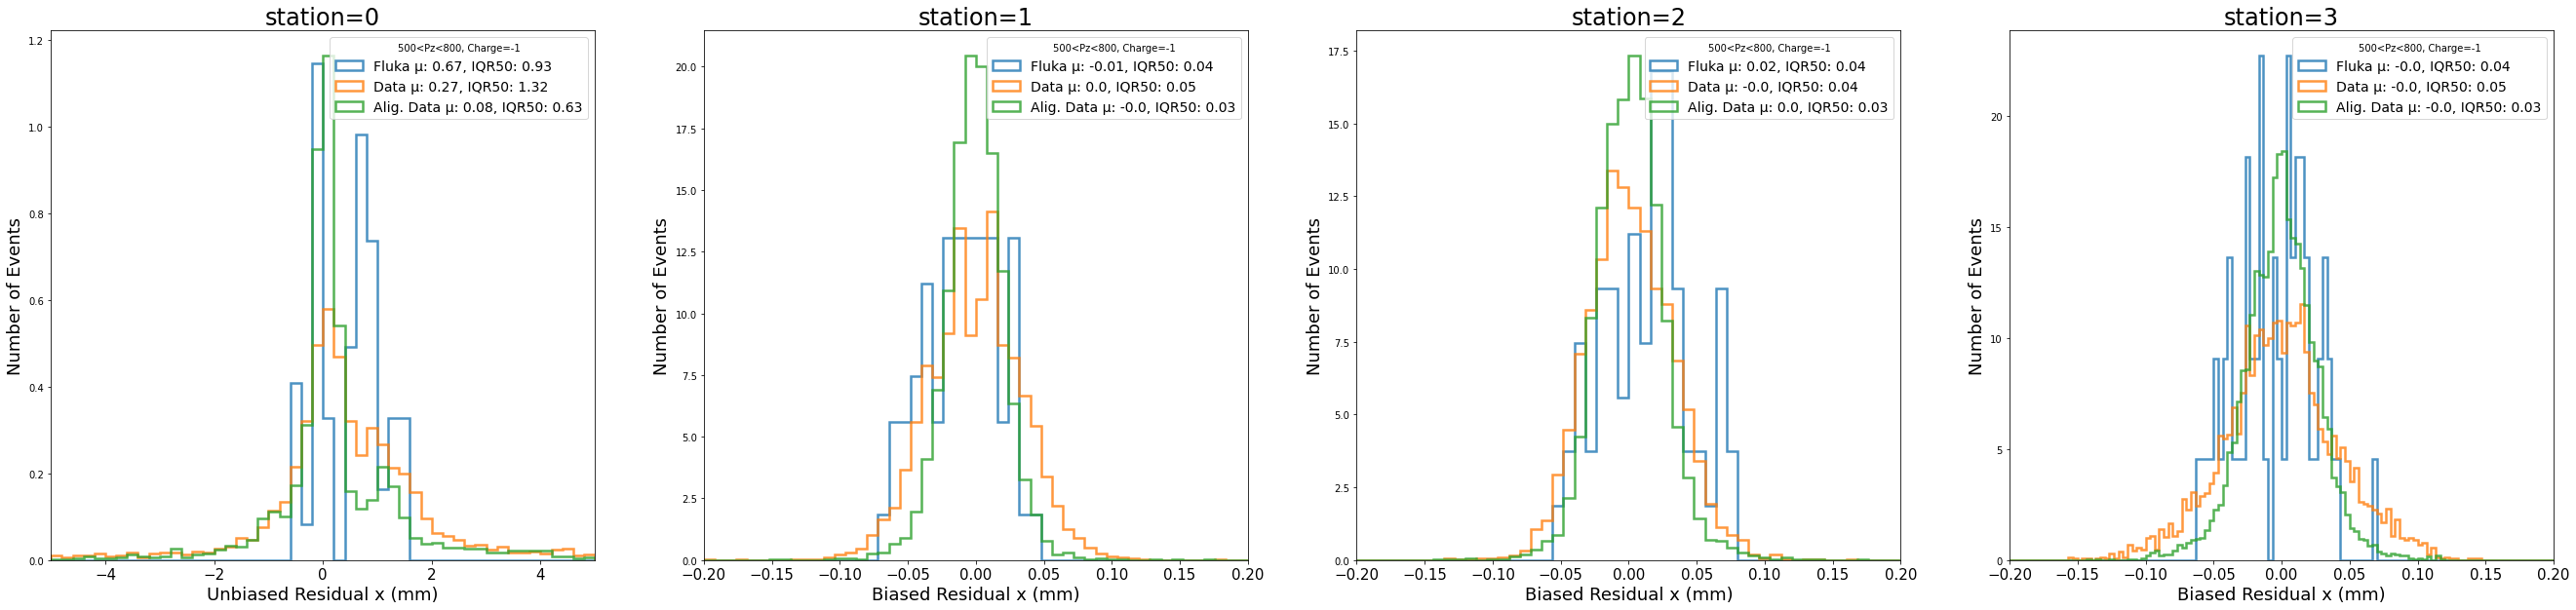

In [102]:
plot(-1, 500, 800, cut_ext)

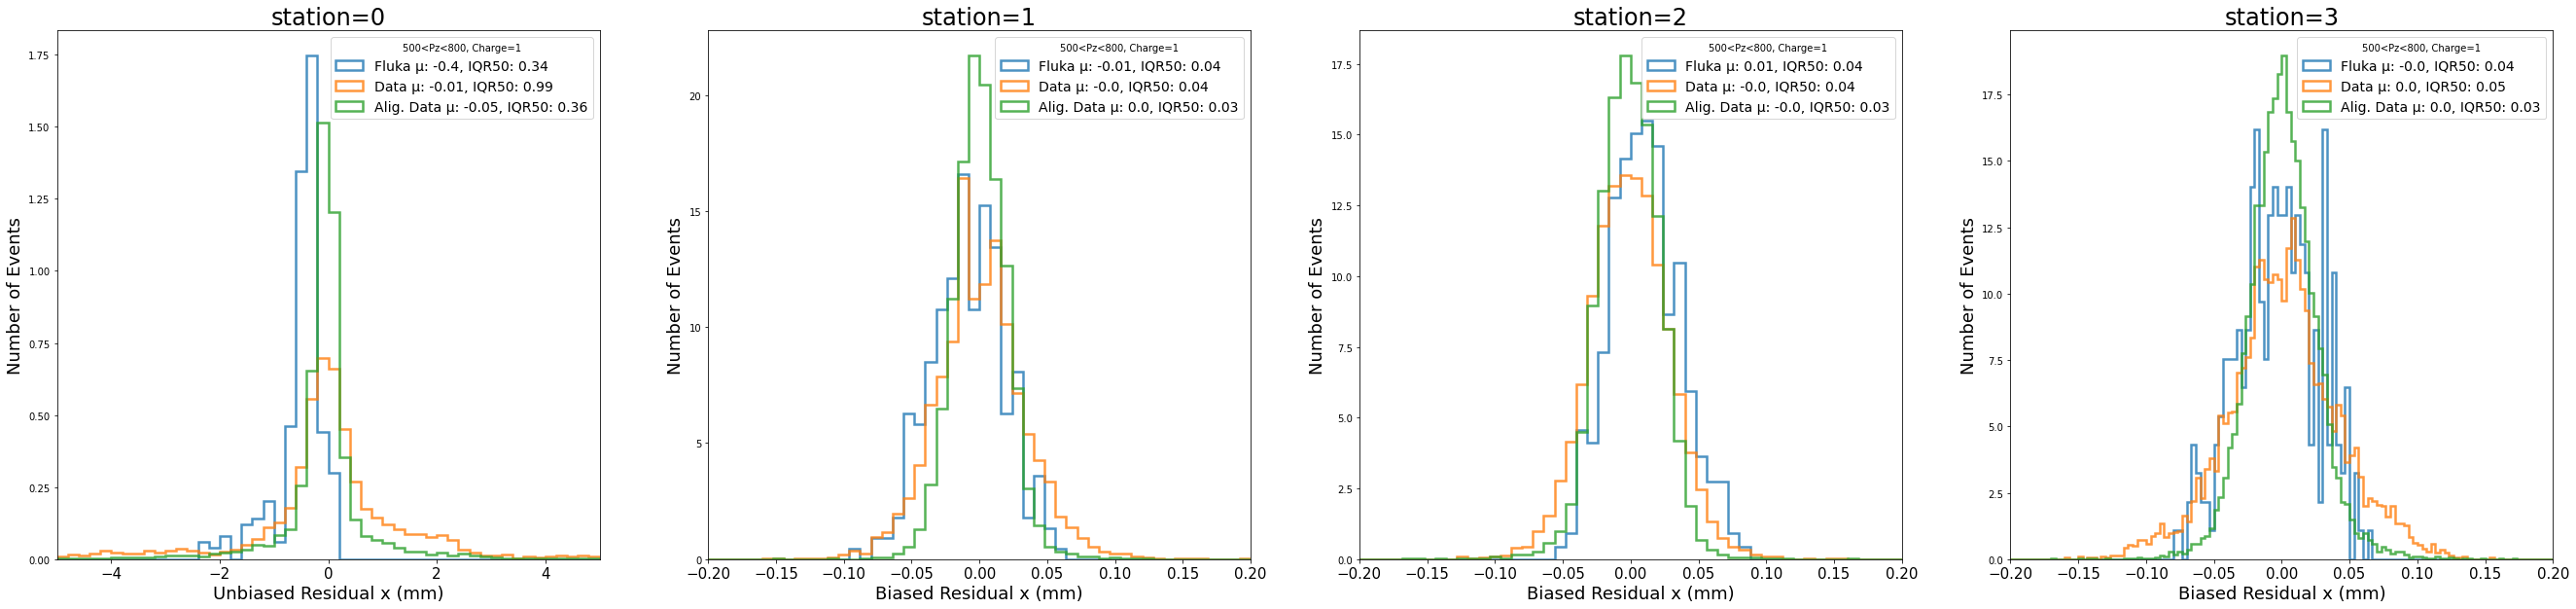

In [103]:
plot(1, 500, 800, cut_ext)

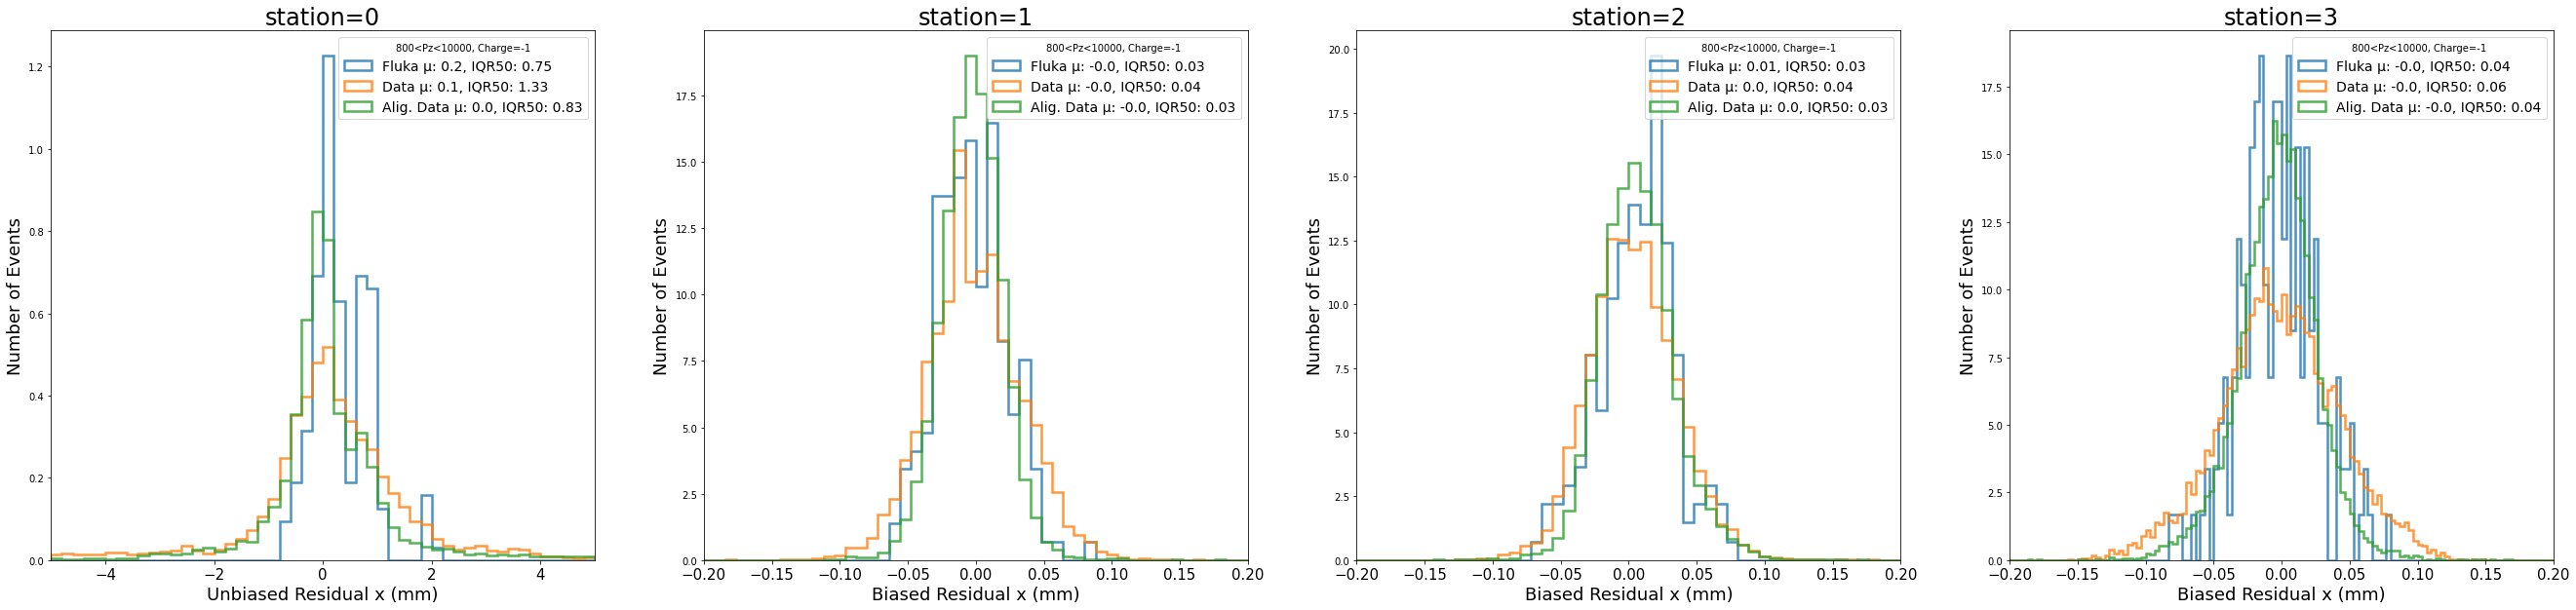

In [104]:
plot(-1, 800, 10000, cut_ext)

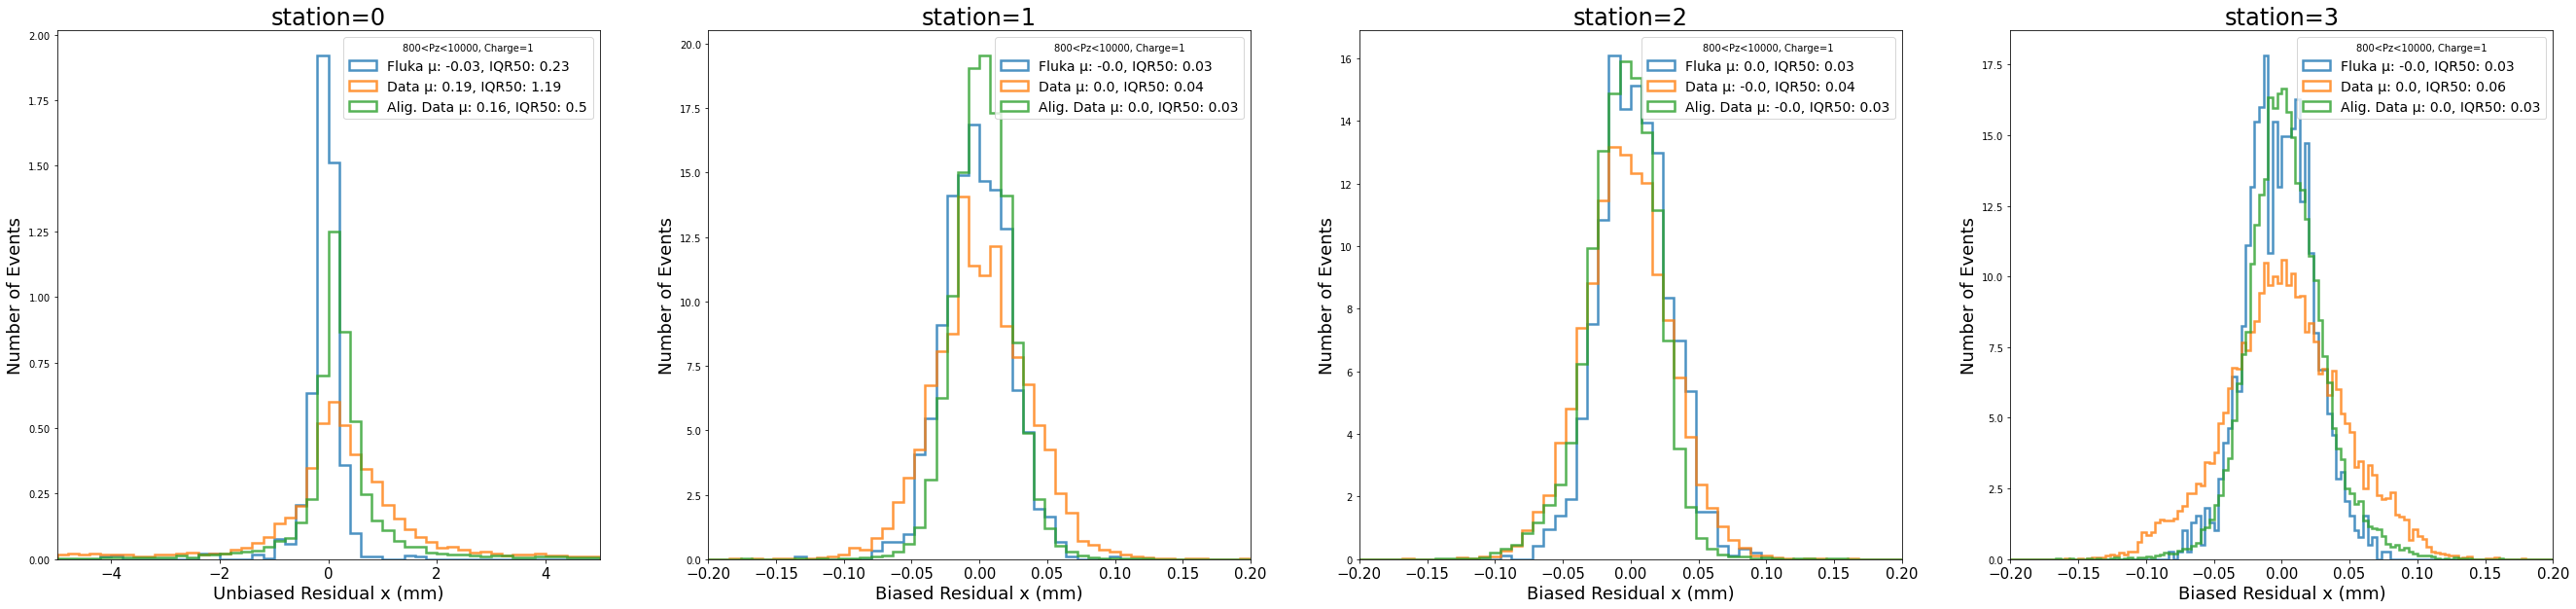

In [105]:
plot(1, 800, 10000, cut_ext)

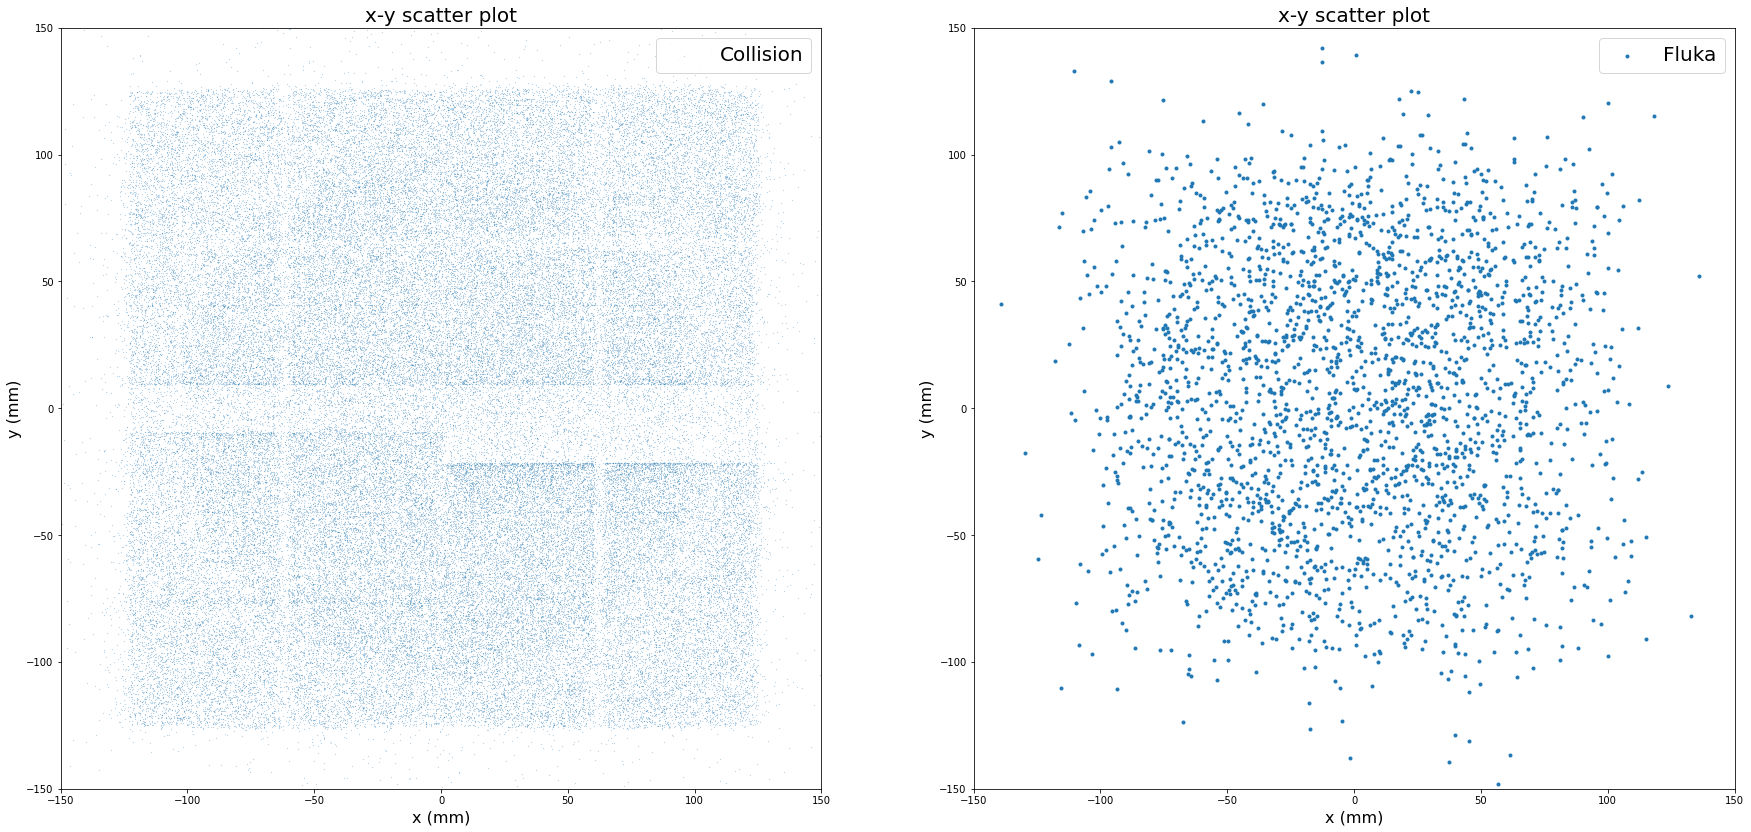

In [106]:
plt.figure(figsize=(30, 14))

plt.subplot(1, 2, 1)
plt.scatter(ak.flatten(collision['fitParam_x']), ak.flatten(collision['fitParam_y']), marker='.', s=.05, label='Collision')
plt.xlim(-150, 150)
plt.ylim(-150, 150)
plt.xlabel('x (mm)', fontsize=16)
plt.ylabel('y (mm)', fontsize=16)
plt.legend(fontsize=20, loc='upper right')
plt.title('x-y scatter plot', fontsize=20)

plt.subplot(1, 2, 2)
plt.scatter(ak.flatten(fluka['fitParam_x']), ak.flatten(fluka['fitParam_y']), marker='.', label='Fluka')
plt.xlim(-150, 150)
plt.ylim(-150, 150)
plt.xlabel('x (mm)', fontsize=16)
plt.ylabel('y (mm)', fontsize=16)
plt.legend(fontsize=20, loc='upper right')
plt.title('x-y scatter plot', fontsize=20)
plt.show()